# Necessary Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix
#for oversampling minority class
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset description

# Understanding dataset and preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/spam_ham_dataset.csv')
data.head()


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
sample = data.sample(5)
for i in range(5):
    print('Class: ', sample.iloc[i]['label'])
    print('Email:')
    print(sample.iloc[i]['text'])
    print('\n', '---'*45)

Class:  ham
Email:
Subject: change name on pipeline , contract no . teco 9121 , global contract no .
96016601
- - - - - - - - - - - - - - - - - - - - - - forwarded by stacey neuweiler / hou / ect on 03 / 24 / 2000
11 : 37 am - - - - - - - - - - - - - - - - - - - - - - - - - - -
marlene hilliard
03 / 24 / 2000 11 : 04 am
to : stacey neuweiler / hou / ect @ ect , rita wynne / hou / ect @ ect , sylvia a
campos / hou / ect @ ect , julie meyers / hou / ect @ ect
cc :
subject : change name on pipeline , contract no . teco 9121 , global contract no .
96016601
please be advised that contract no . teco 9121 shows in the global contract
system as pg & e texas pipeline , l . p . , however , the pipeline name should be
pg & e gas transmission teco , inc . . apparently , the pipeline name was entered
into the global system incorrectly . i have confirmed this with charles berner
in the contracts administration section and kim watson , both with pg & e gas
transmission teco , inc . . the contract nam

In [6]:
#drop the ID column as it is of no use in analysis
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.head()


,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
#check and remove null values if any
data.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [8]:
data['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

Spam : 3672 Ham : 1499


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Email Class'),
 Text(0.5, 1.0, 'Dataset classification')]

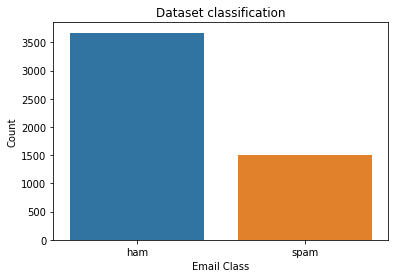

In [33]:
label=['ham','spam']

values=[data['label_num'].value_counts()[0],data['label_num'].value_counts()[1]]
print('Spam : ' +str(values[0]) , 'Ham : ' +str(values[1]) )
ax = sns.barplot(x = label, y = values, data = data)
ax.set(xlabel="Email Class", ylabel = "Count",title='Dataset classification')

Spam email wordcloud


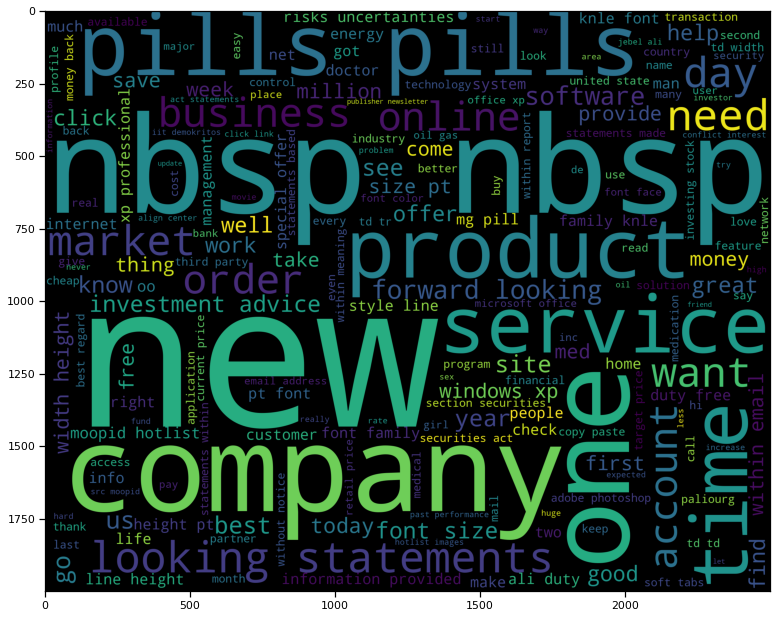

Ham email wordcloud


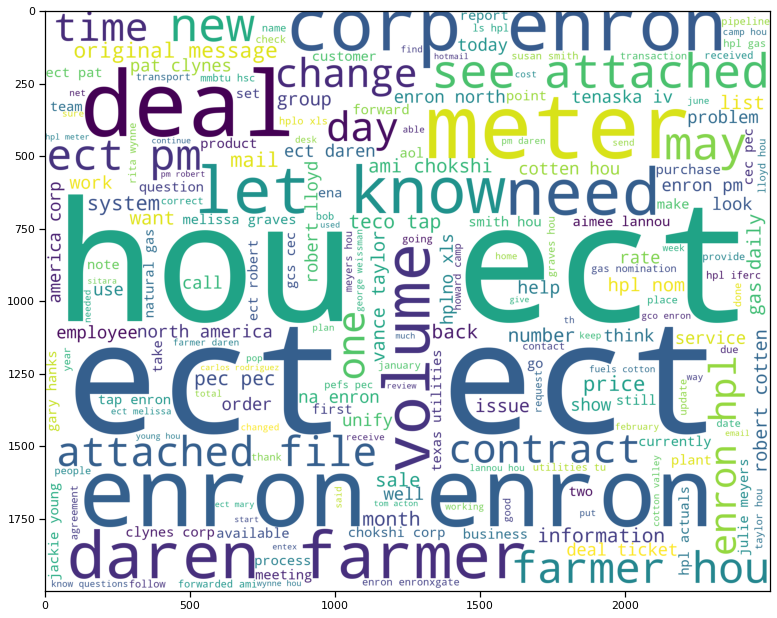

In [ ]:
#draw wordcloud
from wordcloud import WordCloud
sns.set(style = None)
train_spam = train[train['label_num'] == 1]
train_spam = train_spam['text']
#turn series to string by join ' ' to it
train_spam = ' '.join(train_spam)
train_ham = train[train['label_num'] == 0]
train_ham = train_ham['text']
train_ham = ' '.join(train_ham)
wordcloud_spam = WordCloud(background_color = 'black', width = 2500, height = 2000 ).generate(train_spam)
plt.figure(figsize = (13,13))
print('Spam email wordcloud')
plt.imshow(wordcloud_spam)
plt.show()
wordcloud_ham = WordCloud(background_color = 'white', width = 2500, height = 2000).generate(train_ham)
print('Ham email wordcloud')
plt.figure(figsize = (13,13))

plt.imshow(wordcloud_ham)
plt.show()

# Feature extraction

Using TFIDF

In [ ]:
stopwords_set = set(stopwords.words('english'))
stopwords_set.add('subject')
stopwords_set.add('thanks')
stopwords_set.add('cc')
stopwords_set.add('bcc')
stopwords_set.add('please')
stopwords_set.add('http')


def preprocessing_text(x):
    import string
    #lower case
    x = x.lower()
    #remove number
    x = re.sub(r'\d+','',x)
    #remove punctuation
    x = re.sub(r'[^\w\s]', '',x)
    #remove leading and ending space
    x = x.strip()
    #remove stopword
    x = ' '.join([word for word in word_tokenize(x) if not word in stopwords_set])
    return x
#apply preprocessing text on text
data['text'] = data['text'].apply(lambda x: preprocessing_text(x))


In [ ]:
vect = TfidfVectorizer(stop_words=stopwords_set,max_df=0.5, min_df=2)
print(data['text'])
dtm = vect.fit_transform(data['text'])
df = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())
df['target'] = data['label_num']
df.head()

0       enron methanol meter follow note gave monday p...
1       hpl nom january see attached file hplnol xls h...
2       neon retreat ho ho ho around wonderful time ye...
3       photoshop windows office cheap main trending a...
4       indian springs deal book teco pvr revenue unde...
                              ...                        
5166    put ft transport volumes decreased contract am...
5167    following noms hpl take extra mmcf weekend try...
5168    calpine daily gas nomination julie mention ear...
5169    industrial worksheets august activity attached...
5170    important online banking alert dear valued cit...
Name: text, Length: 5171, dtype: object


,aa,aac,aalland,aarhus,aaron,aavilable,ab,aba,ababa,aback,abacus,abacustech,abash,abate,abater,abazis,abb,abbas,abbe,abbot,abbott,abbreviation,abby,abc,abcdef,abdominal,abduct,abdul,abed,abel,aber,aberrant,abet,abetted,abetting,abhorred,abide,abidjan,abie,abigail,...,zevex,zhang,zhongguo,zigzag,zigzagging,zillion,zimbabwe,zimbabwean,zimmer,zinc,zine,zinn,zion,zip,zipper,zipter,zisman,zively,zivley,zj,zko,zn,zocor,zodiac,zoloft,zone,zonedubai,zones,zonewww,zoroastrian,zs,ztop,zu,zur,zurich,zv,zw,zwallet,zwiers,zyban
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(5171, 19710)

# Feature reduction

In [ ]:
x = df.drop('target',axis=1)
y = df['target'] 
x.shape, y.shape

((5171, 19709), (5171,))

####Applying filter methods — Remove constant features

Constant features are the features that contain only one value for all the outputs in the dataset. So they can not give us any valuable pieces of information that could help the classifier. Therefore it is much better to remove them.

In [ ]:
constant_filter = VarianceThreshold(threshold = 0.0002)
constant_filter.fit(x)
feature_list = x[x.columns[
    constant_filter.get_support(indices=True)]]
print('Number of selected features: ' ,len(list(feature_list)),'\n')
print('List of selected features: \n' ,list(feature_list))

Number of selected features:  960 

List of selected features: 
 ['abacustech', 'absence', 'access', 'account', 'accounting', 'activity', 'acton', 'actual', 'actuals', 'add', 'added', 'additional', 'address', 'adjusted', 'adjustments', 'adobe', 'adult', 'advise', 'aep', 'aepin', 'afternoon', 'age', 'agree', 'agreement', 'aimee', 'al', 'allen', 'allocated', 'allocation', 'also', 'alt', 'amazon', 'ami', 'amount', 'anderson', 'anita', 'anything', 'aol', 'apache', 'application', 'approval', 'apr', 'april', 'aquila', 'archer', 'area', 'around', 'assignment', 'atleast', 'attached', 'attachment', 'auction', 'aug', 'august', 'availabilities', 'available', 'avails', 'average', 'avila', 'away', 'back', 'bad', 'bank', 'base', 'based', 'beaumont', 'bed', 'belize', 'bellamy', 'benoit', 'best', 'better', 'beverly', 'big', 'billed', 'biz', 'black', 'boat', 'bob', 'book', 'box', 'br', 'brand', 'brazos', 'brian', 'bridge', 'bruce', 'btu', 'buddy', 'business', 'buy', 'buyback', 'call', 'called', 'calpin

So the result shows us that 94.35 percent of our features are constant ones and the model dropped them. Therefore we removed 11,959 features, which is a considerable number.

In [ ]:
x_filter = constant_filter.transform(x)
x_filter = pd.DataFrame(x_filter)
x_filter.shape

(5171, 960)

####Applying filter methods — Remove correlated features

In [ ]:
def get_correlation(data, threshold):
    corr_col = set()
    cormat = data.corr()
    for i in range(len(cormat.columns)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > threshold:
                colname = cormat.columns[i]
                corr_col.add(colname)
    return corr_col
corr_features = get_correlation(x_filter, 0.70)

In [ ]:
x_uncorr = x_filter.drop(labels= corr_features, axis = 1)
x_uncorr = pd.DataFrame(x_uncorr)
x_uncorr.shape

(5171, 885)

####Applying Linear Discriminant Analysis — LDA

Now we can build an LDA model on our dataset and do feature selection

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
x_lda = lda.fit_transform(x_uncorr, y)
dataset = pd.DataFrame(x_lda)
dataset.shape

(5171, 1)

# Plotting samples in dataset

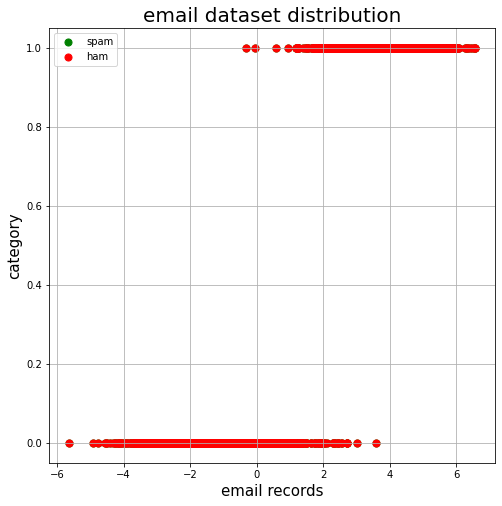

In [ ]:
fig=plt.figure(figsize=(8,8))  
ax=fig.add_subplot(1,1,1)  
ax.set_xlabel('email records',fontsize = 15)  
ax.set_ylabel('category',fontsize = 15)  
ax.set_title('email dataset distribution',fontsize=20)  
targets=['spam', 'ham'] 
colors=['g','r']  
for target,color in zip(targets,colors):
  ax.scatter(x_lda,y,
             c=color,
             s=50)
ax.legend(targets)  
ax.grid()

Spam and Ham class data distribution in Test set
Spam : 742 Ham : 293


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Email Class'),
 Text(0.5, 1.0, 'Test set classification')]

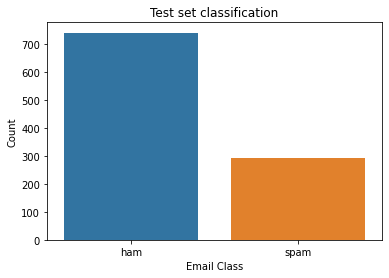

In [35]:
train, test = train_test_split(data, test_size = 0.2, random_state = 42)

print("Spam and Ham class data distribution in Test set")
label=['ham','spam']
values=[test['label_num'].value_counts()[0],test['label_num'].value_counts()[1]]
print('Spam : ' +str(values[0]) , 'Ham : ' +str(values[1]) )
ax = sns.barplot(x = label, y = values, data = test)
ax.set(xlabel="Email Class", ylabel = "Count", title='Test set classification')


# Test Email Classification

## Divide the training and test set

In [36]:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
spam_ham = vectorizer.fit_transform(data['text'])

X= spam_ham
Y= data['label'].values

X_train , X_test , Y_train , Y_test =train_test_split(X, Y, test_size = 0.2, random_state = 42)

## Support Vector Machine Classifier

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train , Y_train)

svm_y_pred_test=clf.predict(X_test)
svm_y_pred_train=clf.predict(X_train)
cm_svm_test=confusion_matrix(Y_test, svm_y_pred_test)
cm_svm_train = confusion_matrix(Y_train , svm_y_pred_train)

accuracy_score(Y_test , svm_y_pred_test)
print(classification_report(svm_y_pred_test, Y_test))


              precision    recall  f1-score   support

         ham       0.97      0.98      0.98       740
        spam       0.94      0.94      0.94       295

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



## Naive Bayes Classifier

In [38]:
NB_classifier =MultinomialNB()
NB_classifier.fit(X_train , Y_train)

Y_pred_train = NB_classifier.predict(X_train)
Y_pred_test = NB_classifier.predict(X_test)

cm_test = confusion_matrix(Y_test, Y_pred_test)
cm_train = confusion_matrix(Y_train , Y_pred_train)

accuracy_score(Y_test , Y_pred_test)
print(classification_report(Y_pred_test, Y_test))


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       742
        spam       0.96      0.96      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035

